In [60]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from typing import Tuple

%matplotlib inline

In [124]:
class JustRNN:
    def __init__(self, max_n: int, hidden_dim: int) -> None:
        self.max_n: int      = max_n
        self.hidden_dim: int = hidden_dim
            
        self.Wxh: np.ndarray = 0.01 * np.random.randn(hidden_dim, max_n + 1)
        self.Whh: np.ndarray = 0.01 * np.random.randn(hidden_dim, hidden_dim)
        self.Why: np.ndarraynp.ndarray = 0.01 * np.random.randn(max_n, hidden_dim)
        
    def forward(self, X: np.ndarray, y: np.ndarray, size: int) -> Tuple[np.ndarray, List[np.ndarray], 
                                                                        List[np.ndarray], float]:  
        hidden_states: List[np.ndarray] = []
        hidden_states.append(np.zeros((self.hidden_dim, 1)))    
        
        probs: List[np.ndarray] = []
        prediction: np.ndarray = np.zeros(size, dtype=np.int32)
        loss: float = 0
        
        pos: int
        for pos in range(size):
            X[self.max_n] = pos
            hidden: np.ndarray = np.tanh(np.dot(self.Wxh, X) + np.dot(self.Whh, hidden_states[-1]))
            hidden_states.append(hidden)

            output: np.ndarray = np.dot(self.Why, hidden)
            prob: np.ndarray = np.exp(output) / np.sum(np.exp(output)) 
            probs.append(prob)

            loss += -np.log(prob[y[pos],0]) 

            prediction[pos] = np.argmax(prob)
            
        return prediction, hidden_states, probs, loss
    
    def backward(self, X: np.ndarray, y: np.ndarray, size: int, 
                 hidden_states: List[np.ndarray], probs: List[np.ndarray]) -> Tuple[np.ndarray, np.ndarray, 
                                                                                    np.ndarray]:
        dWxh: np.ndarray = np.zeros_like(self.Wxh)
        dWhh: np.ndarray = np.zeros_like(self.Whh)
        dWhy: np.ndarray = np.zeros_like(self.Why)
        dhnext: np.ndarray = np.zeros_like(hidden_states[0])
        
        pos: int
        for pos in reversed(range(size)):
            X[self.max_n] = pos
            dy: np.ndarray = np.copy(probs[pos])
            dy[y[pos]] -= 1 

            dWhy += np.dot(dy, hidden_states[pos].T)
            
            dh: np.ndarray = np.dot(self.Why.T, dy) + dhnext 
            dhraw: np.ndarray = (1 - hidden_states[pos] * hidden_states[pos]) * dh 
            
            dWxh += np.dot(dhraw, X.T)
            dWhh += np.dot(dhraw, hidden_states[pos-1].T)
            
            dhnext = np.dot(self.Whh.T, dhraw)
            
        for dparam in [dWxh, dWhh, dWhy]:
            # clip to mitigate exploding gradients
            np.clip(dparam, -5, 5, out=dparam) 
            
        return dWxh, dWhh, dWhy
        
    def train(self, max_examples: int, learning_rate: float, max_seq_len: int, lr_lambda: float = 0.4, 
            lr_reduce_rate: int = 500, info_rate: int = 100) -> List[float]:
        
        correct_preds: float = 0
        all_preds: int       = 0
        accur_list: List[float] = []
            
        for i in range(max_examples):
            sequence_size: int = max_seq_len
            
            X: np.ndarray = np.random.randint(self.max_n, size=sequence_size)
            y: np.ndarray = np.sort(X)

            one_hot: np.ndarray = np.zeros((self.max_n + 1, 1))
            one_hot[X, :] = 1
            
            prediction: np.ndarray
            hidden_states: List[np.ndarray]
            probs: List[np.ndarray]
            loss: float
            prediction, hidden_states, probs, loss = self.forward(one_hot, y, sequence_size)
                
            correct_preds += np.sum(prediction == y)
            all_preds     += y.shape[0]
            
            dWxh, dWhh, dWhy = self.backward(one_hot, y, sequence_size, 
                                        hidden_states, probs)
            
            self.Wxh += -learning_rate * dWxh
            self.Whh += -learning_rate * dWhh
            self.Why += -learning_rate * dWhy
            
            if (i + 1) % lr_reduce_rate == 0:
                learning_rate *= lr_lambda

            if (i + 1) % info_rate == 0:
                accuracy: float = correct_preds / all_preds
                accur_list.append(accuracy)
                print('Accuracy for last 100 sequences = {}'.format(accuracy))
                correct_preds = 0
                all_preds     = 0
                
        return accur_list
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        one_hot: np.ndarray = np.zeros((self.max_n + 1, 1))
        one_hot[X, :] = 1
        seq_size:int = X.shape[0]
        prediction: np.ndarray = np.zeros(seq_size, dtype=np.int32)
            
        hidden_states: List[np.ndarray] = []
        hidden_states.append(np.zeros((self.hidden_dim, 1)))   
        
        pos: int
        for pos in range(seq_size):
            one_hot[self.max_n] = pos
            
            hidden: np.ndarray = np.tanh(np.dot(self.Wxh, one_hot) + np.dot(self.Whh, hidden_states[-1]))
            hidden_states.append(hidden)
            
            output: np.ndarray = np.dot(self.Why, hidden)
            prob: np.ndarray = np.exp(output) / np.sum(np.exp(output)) 

            prediction[pos] = np.argmax(prob)
            
        return prediction
            

In [125]:
max_number: int = 10
hidden_dim: int = 1024
model: JustRNN = JustRNN(max_number, hidden_dim)
max_seq_len = 10

In [139]:
X: np.ndarray = np.random.randint(max_number, size=max_seq_len)
print('{} = X'.format(X))
print('{} = Target'.format(np.sort(X)))
print('{} = Before training prediction'.format(model.predict(X)))

[3 3 0 8 1 7 1 0 2 9] = X
[0 0 1 1 2 3 3 7 8 9] = Target
[6 6 6 6 6 6 9 9 9 9] = Before training prediction


In [127]:
max_examples: int = 1300
learning_rate: float = 6e-3
accur_list: List[float] = model.train(max_examples, learning_rate, max_seq_len)

Accuracy for last 100 sequences = 0.189
Accuracy for last 100 sequences = 0.313
Accuracy for last 100 sequences = 0.306
Accuracy for last 100 sequences = 0.342
Accuracy for last 100 sequences = 0.426
Accuracy for last 100 sequences = 0.442
Accuracy for last 100 sequences = 0.51
Accuracy for last 100 sequences = 0.482
Accuracy for last 100 sequences = 0.508
Accuracy for last 100 sequences = 0.536
Accuracy for last 100 sequences = 0.521
Accuracy for last 100 sequences = 0.543
Accuracy for last 100 sequences = 0.577


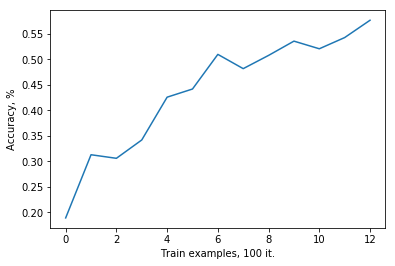

In [128]:
plt.plot(accur_list, label='Accuracy')
plt.xlabel('Train examples, 100 it.')
plt.ylabel('Accuracy, %')
plt.show()

In [140]:
print('{} = X'.format(X))
print('{} = Target'.format(np.sort(X)))
print('{} = After training prediction'.format(model.predict(X)))

[3 3 0 8 1 7 1 0 2 9] = X
[0 0 1 1 2 3 3 7 8 9] = Target
[0 1 1 2 3 3 7 8 8 9] = After training prediction
